<a href="https://colab.research.google.com/github/allenphos/ML-course-ua-/blob/main/Copy_of_HW_2_4_kNN_%D0%9A%D1%80%D0%BE%D1%81%D0%B2%D0%B0%D0%BB%D1%96%D0%B4%D0%B0%D1%86%D1%96%D1%8F_%D1%96_%D1%82%D1%8E%D0%BD%D0%B8%D0%BD%D0%B3_%D0%B3%D1%96%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%96%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install opendatasets --upgrade --quiet

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.plotting import plot_decision_regions

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [8]:
import opendatasets as od

# Download the dataset
od.download("https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2")

raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/bank_churn_project')

In [7]:
%load_ext autoreload
%autoreload 2

from process_bank_churn import preprocess_data

data = preprocess_data(
    raw_df=raw_df,
    target_col="Exited",
    drop_cols=["CustomerId", "Surname"]
)

X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/content/drive/MyDrive/Colab Notebooks/bank_churn_project/process_bank_churn.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
/content/drive/MyDrive/Colab Notebooks/bank_churn_project/process_bank_churn.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [10]:
raw_df.select_dtypes(include=np.number).corr().Exited.to_frame().style.background_gradient()

,Exited
CustomerId,-0.031537
CreditScore,-0.047703
Age,0.464689
Tenure,-0.011637
Balance,0.153025
NumOfProducts,-0.288563
HasCrCard,-0.017616
IsActiveMember,-0.193615
EstimatedSalary,0.023796
Exited,1.000000


### Decision boundaries

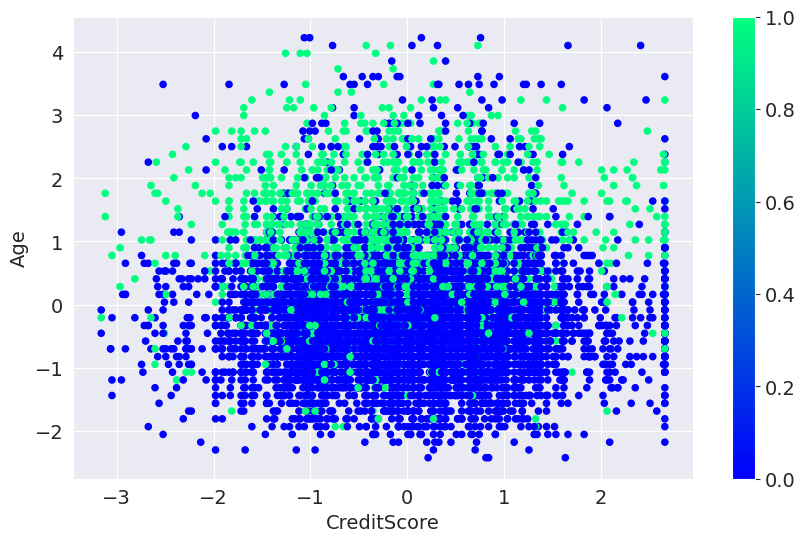

In [14]:
X_train.plot.scatter(x='CreditScore', y='Age', c=train_targets, cmap='winter', figsize=(10,6));

## kNN

In [15]:
knn = KNeighborsClassifier()
# Training the model on the training data
knn.fit(X_train, train_targets)

# Predicting probabilities for training and validation data
train_probs = knn.predict_proba(X_train)[:, 1]
val_probs = knn.predict_proba(X_val)[:, 1]

# Calculating AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_probs)
val_auroc = roc_auc_score(val_targets, val_probs)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

AUROC на тренувальних даних: 0.9613364294764178
AUROC на валідаційних даних: 0.8745388540905226


На тренувальному наборі модель показує дуже гарний результат 0.96 (1 найкраще значення), але на валідаційному наборі точність трохи гірша, що вказує на перенавчання (overfitting). Модель kNN має високу дисперсію (high variance) та низький зсув (low bias).

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [29]:
# Define the parameter grid
params_knn = {'n_neighbors': np.arange(1, 25)}
# Initialize the kNN classifier
knn = KNeighborsClassifier()
# Initialize GridSearchCV
knn_gs = GridSearchCV(knn, params_knn, cv=5)
# Fit the model
knn_gs.fit(X_train, train_targets)

# Get the best estimator
knn_best = knn_gs.best_estimator_

print(f"Best parameters: {knn_gs.best_params_}")
print(f"Best score: {knn_gs.best_score_}")

Best parameters: {'n_neighbors': 21}
Best score: 0.8826666666666666


In [27]:
knn_gs.best_estimator_

KNeighborsClassifier(n_neighbors=21)

In [30]:
# Predict probabilities using the best model
train_probs = knn_best.predict_proba(X_train)[:, 1]  # Use knn_best for prediction
val_probs = knn_best.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_probs)
val_auroc = roc_auc_score(val_targets, val_probs)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

AUROC on training data: 0.9380710564380789
AUROC on validation data: 0.9044844791217794


На тестовому наборі даних значення трохи зменшилось 0.93, але на валідаційному наборі точність виросла до 0.90 в порівнянні з 0.88. Більше немає значного преренавчання і модель гарно генералізує.

Значення набагато кращі за ті, які були отримані з деревом прийняття рішень.

AUROC for Training: 1.00
AUROC for Validation: 0.76

## DecisionTreeClassifier with GridSearchCV

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [33]:
import time

# Initialize the DecisionTreeClassifier with random_state
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
params_dt = {
    'max_depth': range(1, 21, 2),  # From 1 to 20 with step 2
    'max_leaf_nodes': range(2, 11)  # From 2 to 10 with step 1
}

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(dt, params_dt, cv=3, scoring='roc_auc')

# Measure the time taken for grid search
start_time = time.time()
grid_search_dt.fit(X_train, train_targets)
end_time = time.time()

# Get the best model
dt_best = grid_search_dt.best_estimator_

# Print the best parameters, score, and time taken
print(f"Best parameters: {grid_search_dt.best_params_}")
print(f"Best score: {grid_search_dt.best_score_}")
print(f"Time taken for grid search: {end_time - start_time:.2f} seconds")

Best parameters: {'max_depth': 5, 'max_leaf_nodes': 10}
Best score: 0.9004501498257822
Time taken for grid search: 4.93 seconds


In [34]:
# Predict probabilities using the best model
train_probs = dt_best.predict_proba(X_train)[:, 1]
val_probs = dt_best.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_probs)
val_auroc = roc_auc_score(val_targets, val_probs)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

AUROC on training data: 0.901388106858227
AUROC on validation data: 0.9015122502961266


Модель ще краще генералізує, зараз значення майже однакові на двох наборах. Але точність трохи погіршилась: 0.9044 проти 0.9015 на валідаційному, та 0.9013 проти 0.9380 на тренувальному.

## DecisionTreeClassifier with RandomizedSearchCV

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [35]:
?RandomizedSearchCV

In [36]:
# Define the parameter grid
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [41]:
# Initialize the DecisionTreeClassifier with random_state
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    dt,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring="roc_auc",
    verbose=1,
    refit=True,
    random_state=42
)

# Measure the time taken for random search
start_time = time.time()
random_search_dt.fit(X_train, train_targets)
end_time = time.time()

# Get the best model
dt_random_search_best = random_search_dt.best_estimator_

# Print the best parameters, score, and time taken
print(f"Best parameters: {random_search_dt.best_params_}")
print(f"Best score: {random_search_dt.best_score_}")
print(f"Time taken for grid search: {end_time - start_time:.2f} seconds")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Best score: 0.9100040535406059
Time taken for grid search: 2.04 seconds


In [38]:
# Predict probabilities using the best model
train_probs = dt_random_search_best.predict_proba(X_train)[:, 1]
val_probs = dt_random_search_best.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_probs)
val_auroc = roc_auc_score(val_targets, val_probs)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

AUROC on training data: 0.9171536926351466
AUROC on validation data: 0.9157677818205237


Модель з RandomizedSearchCV має краще значення 0.91 на двох наборах.

In [43]:
dt_best

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=42)

In [42]:
dt_random_search_best

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

**DecisionTreeClassifier with GridSearchCV:**

- Best parameters: {'max_depth': 5, 'max_leaf_nodes': 10}
- Best score: 0.9004501498257822

- Time taken for grid search: 4.93 seconds

**DecisionTreeClassifier with RandomizedSearchCV:**

- Best parameters: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
- Best score: 0.9100040535406059
- Time taken for grid search: 2.62 seconds

DecisionTreeClassifier з RandomizedSearchCV має більше max_leaf_nodes 14 проти 10 з GridSearchCV. А глибина дерева сягає 16 проти 5. В останній моделі вище score, та вона майже в 2 рази швидше впоралась з задачею. В RandomizedSearchCV було занесено більше параметрів, які й впринули на результат.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [46]:
# Initialize the DecisionTreeClassifier with random_state
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
model = RandomizedSearchCV(
    dt,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring="roc_auc",
    verbose=1,
    refit=True,
    random_state=42
)

model.fit(X_train, train_targets)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc', verbose=1)

In [48]:
from process_bank_churn import preprocess_new_data

test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv')

preprocessed_test = preprocess_new_data(test_raw_df, data['input_cols'], data['scaler'], data['encoder'])

# Make predictions using the trained model
predictions = model.predict_proba(preprocessed_test)[:,1] # Get the predictions

# Assign predictions to the 'Exited' column
test_raw_df['Exited'] = predictions

sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')
sample_submission = sample_submission.reset_index(drop=True)
test_raw_df = test_raw_df.reset_index(drop=True)
sample_submission['Exited'] = test_raw_df['Exited']

sample_submission.to_csv('submission_tree_randomizedsearchCV.csv', index=False)

sample_submission['Exited']

,Exited
0,0.246753
1,0.012071
2,0.193182
3,0.558011
4,0.082278
...,...
9995,0.012071
9996,0.012071
9997,0.012071
9998,0.039863


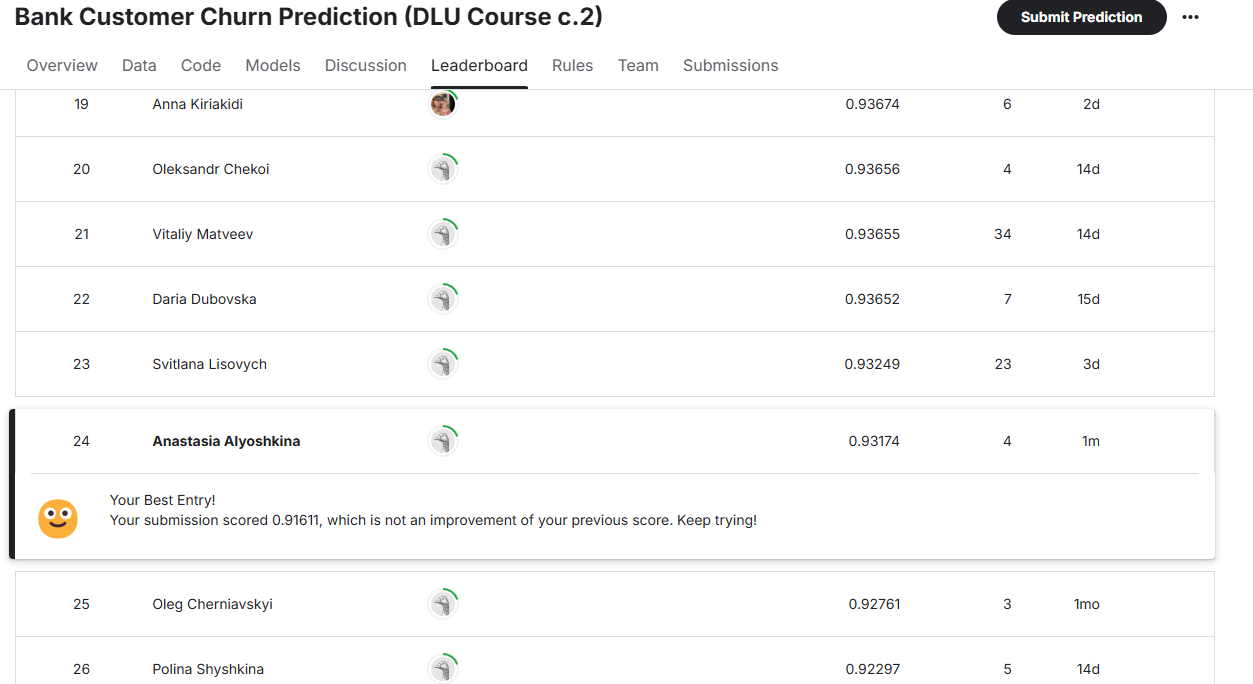